In [1]:
import os
import sys
import time
import pickle as pk
from typing import Union, Tuple
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.autograd import grad
from torch.nn import Parameter
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchsummary import summary

In [2]:
torch.cuda.is_available()

True

In [75]:
def get_mnist_data():
  train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
  train_loader = DataLoader(train_data, batch_size=len(train_data))
  batch = next(iter(train_loader))
  x, y = batch
  mean, std = torch.mean(x), torch.std(x)
  transform  = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
  ])
  
  train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
  test_data = datasets.MNIST('data', train=False, download=True, transform=transform)
  return train_data, test_data

In [76]:
def get_mnist_loaders(batch_size):
  train_data, test_data = get_mnist_data()

  yield DataLoader(train_data, batch_size=batch_size, shuffle=True)
  yield DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [4]:
batch_size = 64
train_loader, test_loader = get_mnist_loaders(batch_size)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [43]:
class ConvActNorm(nn.Sequential):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    nn.Sequential.__init__(self, OrderedDict([
      ('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)),
      ('relu', nn.LeakyReLU()),
      ('bnorm', nn.BatchNorm2d(out_channels)),
    ]))

In [44]:

class TConvActNorm(nn.Sequential):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    nn.Sequential.__init__(self, OrderedDict([
      ('tconv', nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)),
      ('relu', nn.LeakyReLU()),
      ('bnorm', nn.BatchNorm2d(out_channels)),
    ]))

In [29]:
class Encoder(nn.Sequential):
  def __init__(self, channels, kernel_sizes, strides, paddings):
    layers = []
    for i in range(len(channels) - 1):
      layers.append((f'block_{i + 1}', ConvActNorm(channels[i], channels[i + 1], kernel_sizes[i], strides[i], paddings[i])))
    nn.Sequential.__init__(self, OrderedDict(layers))

In [30]:

class Decoder(nn.Sequential):
  def __init__(self, channels, kernel_sizes, strides, paddings):
    layers = []
    for i in range(len(channels) - 1):
      layers.append((f'block_{i + 1}', TConvActNorm(channels[i], channels[i + 1], kernel_sizes[i], strides[i], paddings[i])))
    nn.Sequential.__init__(self, OrderedDict(layers))

In [31]:
class AutoEncoder(nn.Module):
  def __init__(self, channels, kernel_sizes, strides, paddings):
    nn.Module.__init__(self)
    self.encoder = Encoder(channels, kernel_sizes, strides, paddings)
    self.decoder = Decoder(list(reversed(channels)), list(reversed(kernel_sizes)), list(reversed(strides)), list(reversed(paddings)))
  
  def forward(self, x):
    return self.decoder(self.encoder(x))

In [69]:
# Like train, but drops target from the dataset and instead uses X as target
def train_identity(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
  
  use_test = False
  if isinstance(data, DataLoader):
    train_loader = data
    train_loader = data
  elif isinstance(data, tuple):
    if len(data) == 2:
      train_loader, test_loader = data
      if not isinstance(train_loader, DataLoader):
        raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
      if not isinstance(test_loader, DataLoader):
        raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
      use_test = True
    else:
      raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
  
  criterion = nn.MSELoss()
  model.train()
  losses = []
  batch_total = len(train_loader)
  train_losses = dict()
  test_losses = dict()

  for epoch in range(max_epochs):
    for batch_idx, batch in enumerate(train_loader):
      # We do not need y from the batch
      x, _ = batch
      if cuda:
        x = x.cuda()
      output = model(x)
      loss = criterion(output, x)
      loss.backward()
      optimizer.step()
      
      losses.append(loss.item())

      if batch_idx % 50 == 0 or batch_idx == batch_total - 1:
        train_losses[epoch + batch_idx / batch_total] = loss.item()
        if use_test:
          model.eval()

          test_x, _ = next(iter(test_loader))
          if cuda:
            test_x = test_x.cuda()
          test_output = model(test_x)
          test_loss = criterion(test_output, test_x)
          test_losses[epoch + batch_idx / batch_total] = test_loss.item()
          
          model.train()

          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Test loss: {test_loss:.6f}')
        else:
          sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f}')

  return losses, train_losses, test_losses

In [57]:
ae_summary_model1 = AutoEncoder([1, 4, 16, 16], [2, 3, 3], [2] * 3, [1, 0, 0])
summary(ae_summary_model1, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 15, 15]              20
         LeakyReLU-2            [-1, 4, 15, 15]               0
       BatchNorm2d-3            [-1, 4, 15, 15]               8
            Conv2d-4             [-1, 16, 7, 7]             592
         LeakyReLU-5             [-1, 16, 7, 7]               0
       BatchNorm2d-6             [-1, 16, 7, 7]              32
            Conv2d-7             [-1, 16, 3, 3]           2,320
         LeakyReLU-8             [-1, 16, 3, 3]               0
       BatchNorm2d-9             [-1, 16, 3, 3]              32
  ConvTranspose2d-10             [-1, 16, 7, 7]           2,320
        LeakyReLU-11             [-1, 16, 7, 7]               0
      BatchNorm2d-12             [-1, 16, 7, 7]              32
  ConvTranspose2d-13            [-1, 4, 15, 15]             580
        LeakyReLU-14            [-1, 4,

Latent dimension size: 144 (3 * 3px * 16chan)

In [65]:
train_info = {}

In [73]:
%%time
model = AutoEncoder([1, 4, 16, 16], [2, 3, 3], [2] * 3, [1, 0, 0]).cuda()
opt = optim.Adam(model.parameters(), lr=1e-3)
train_info[1] = train_identity(model, opt, tuple(get_mnist_loaders(64)), 10)
ae_model1 = model

Epoch: 9/10 Step: 937/938 Loss: 0.224896 Test loss: 0.205517CPU times: user 2min 25s, sys: 779 ms, total: 2min 26s
Wall time: 2min 26s


In [67]:
colors = plt.cm.tab20(np.linspace(0, 1, 20))

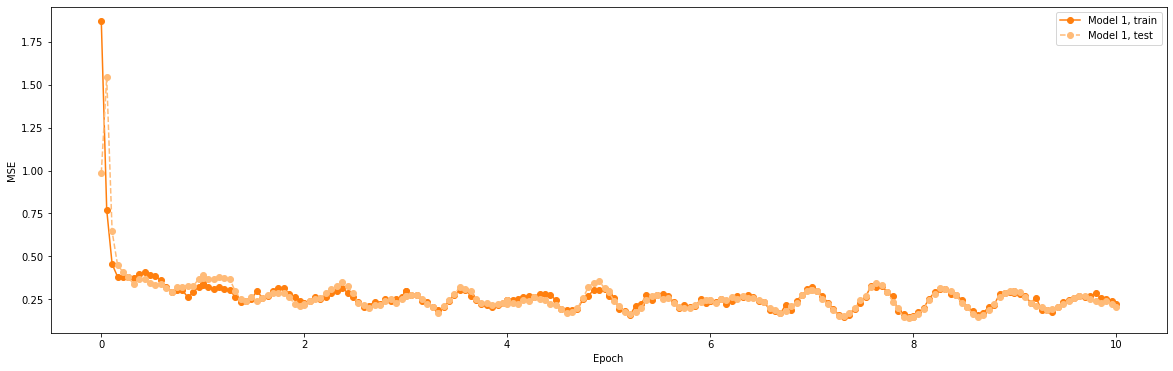

In [74]:
plt.figure(figsize=(20, 6))
plt.plot(*zip(*train_info[1][1].items()), '-o', color=colors[2], label=f'Model 1, train')
plt.plot(*zip(*train_info[1][2].items()), '--o', color=colors[3], label=f'Model 1, test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [97]:
raw_train_images = get_mnist_data()[0].data.float().cuda()

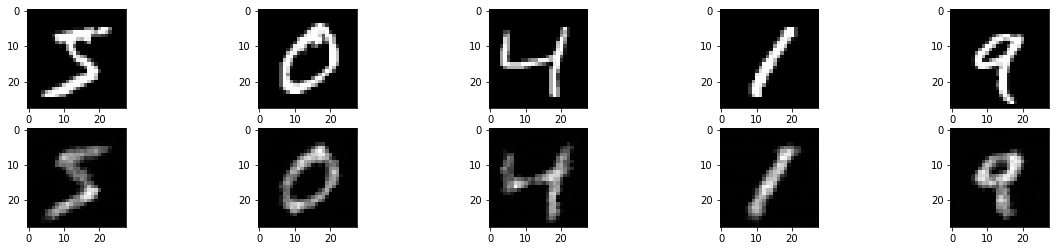

In [106]:
plt.figure(figsize=(20, 4))
for i, idx in enumerate(range(5)):
  plt.subplot(2, 5, i + 1)
  plt.imshow(raw_train_images[idx].cpu(), cmap='gray')
  plt.subplot(2, 5, i + 6)
  plt.imshow(ae_model1(raw_train_images[idx].reshape(1, 1, 28, 28)).cpu().detach().reshape(28, 28), cmap='gray')

In [109]:

ae_summary_model2 = AutoEncoder([1, 2, 4, 4], [2, 3, 5], [2] * 3, [1, 0, 0])
summary(ae_summary_model2, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 15, 15]              10
         LeakyReLU-2            [-1, 2, 15, 15]               0
       BatchNorm2d-3            [-1, 2, 15, 15]               4
            Conv2d-4              [-1, 4, 7, 7]              76
         LeakyReLU-5              [-1, 4, 7, 7]               0
       BatchNorm2d-6              [-1, 4, 7, 7]               8
            Conv2d-7              [-1, 4, 2, 2]             404
         LeakyReLU-8              [-1, 4, 2, 2]               0
       BatchNorm2d-9              [-1, 4, 2, 2]               8
  ConvTranspose2d-10              [-1, 4, 7, 7]             404
        LeakyReLU-11              [-1, 4, 7, 7]               0
      BatchNorm2d-12              [-1, 4, 7, 7]               8
  ConvTranspose2d-13            [-1, 2, 15, 15]              74
        LeakyReLU-14            [-1, 2,

Latent dimension size: 16 (2 * 2px * 4chan)

In [111]:
 %%time
model = AutoEncoder([1, 2, 4, 4], [2, 3, 5], [2] * 3, [1, 0, 0]).cuda()
opt = optim.Adam(model.parameters(), lr=1e-3)
train_info[2] = train_identity(model, opt, tuple(get_mnist_loaders(64)), 10)
ae_model2 = model

Epoch: 9/10 Step: 937/938 Loss: 0.468776 Test loss: 0.482118CPU times: user 2min 18s, sys: 777 ms, total: 2min 19s
Wall time: 2min 19s


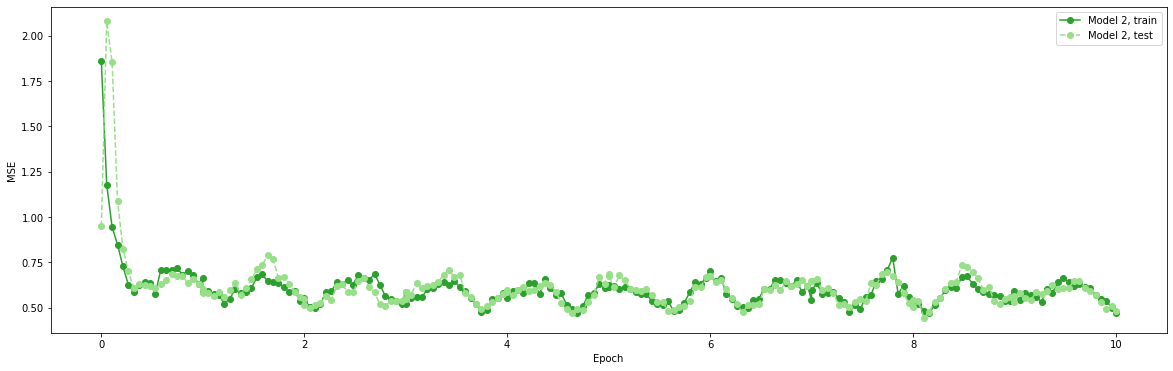

In [112]:
plt.figure(figsize=(20, 6))
plt.plot(*zip(*train_info[2][1].items()), '-o', color=colors[4], label=f'Model 2, train')
plt.plot(*zip(*train_info[2][2].items()), '--o', color=colors[5], label=f'Model 2, test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

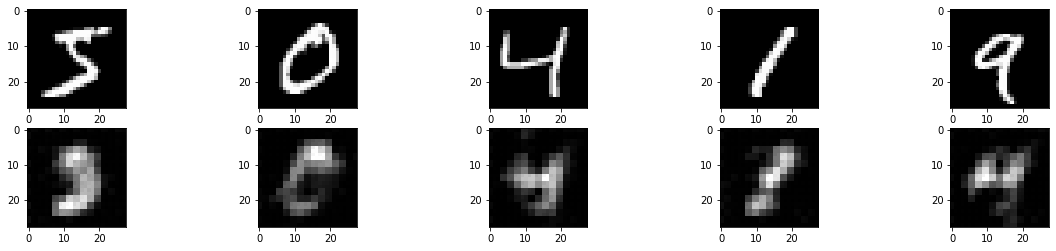

In [113]:
plt.figure(figsize=(20, 4))
for i, idx in enumerate(range(5)):
  plt.subplot(2, 5, i + 1)
  plt.imshow(raw_train_images[idx].cpu(), cmap='gray')
  plt.subplot(2, 5, i + 6)
  plt.imshow(ae_model2(raw_train_images[idx].reshape(1, 1, 28, 28)).cpu().detach().reshape(28, 28), cmap='gray')

In [123]:

class VariationalAutoEncoder(nn.Module):
  def __init__(self, channels, kernel_sizes, strides, paddings):
    nn.Module.__init__(self)
    self.encoder = Encoder(channels, kernel_sizes, strides, paddings)
    self.decoder = Decoder(list(reversed(channels)), list(reversed(kernel_sizes)), list(reversed(strides)), list(reversed(paddings)))
  
  def forward(self, x):
    z_enc = self.encoder(x)
    orig_shape = z_enc.shape
    z_enc = z_enc.reshape(z_enc.shape[0], -1)
    mu, sigma = z_enc.mean(dim=0), z_enc.std(dim=0)
    q = torch.distributions.Normal(mu, torch.diag(sigma))
    z_sample = q.rsample()
    x_dec = self.decoder(z_sample.reshape(*orig_shape))
    